# Benchmarking by comparing to analytical and theoretical results

## TODO :

Analyse des premiers résultats :
- variation assez élevée du nombre de particules quittant le système à un instant donné (<25, mais varie entre 5 et 25)
- les débits massiques en sortie ne correspondent pas (mais ça peut être normal, pour le coup ça dépend pas mal de données rentrées sur le site)
Pour la suite, je vais essayer de comparer sur plusieurs nombre de particules par cellule : 100 - 200 - 500 - 1000 - 2000 - 5000 - 10000, pour commencer, sur environ $10^{-4}$ secondes. Soit, avec $dt = 5 \times 10^{-7}$, on doit faire 10000 pas de temps.

Avant cela, il y a également le problème des pas de temps et d'espace. Dans cet [article](https://www.sciencedirect.com/science/article/pii/S0045793015002558), on voit que les contraintes sont au nombre de quatre et plus subtiles que ce que j'ai considéré jusqu'à présent.


## Comparison with flow in tube

[Link](http://fisica.ufpr.br/sharipov/tube.html)


Speed of sound : 
 $$ v = \sqrt{\frac{\gamma R T_K}{M}}$$
with : 
* $\gamma$ : the adiabatic index
* $R = 8.314 \text{ J.K.mol}^{-1}$ the gas constant
* $T_K$ the temperature in Kelvin
* $M$ the molecular mass


For our case with Iodine $[I]$ :
* $\gamma = \frac{5}{3}$
* $T_K = 300 \text{ K}$
* $M \approx 126.9 \text{ g.mol}^{-1}$

Which yields : $v \approx  \text{ m.s}^{-1}$

In [3]:
import numpy as np
def speed_of_sound(molecular_mass, temperature, gamma):
    # all units in SI
    return np.sqrt(8.314*gamma*temperature/molecular_mass)

In [5]:
gamma = 5/3.
molecular_mass = 0.1269 # kg/mol
temperature = 300 # K
v = speed_of_sound(molecular_mass, temperature, gamma)
print(f'Speed of sound for iodine [I] at temperature 300 K : {v} m/s')

Speed of sound for iodine [I] at temperature 300 K : 180.99192585903475 m/s


### Definition of the tube

Imports : 

In [9]:
%matplotlib inline

# system
from src.system_creator import SystemCreator

# Grid
from src.utils import Grid, pos_in_grid, convert_to_grid_datatype

# Particles
from src.utils import Particle

# injection 
from src.utils import inject

# advection
from src.utils import advect
from src.utils import euler_explicit, leap_frog

# collisions
from src.utils import handler_wall_collision, handler_wall_collision_point, make_collisions_vectorized, make_collisions_out_walls, deal_with_corner

# utils 
from src.utils import gaussian, maxwellian_flux, maxwellian_mean_speed, get_mass_part, mean_free_path, mean_free_time

# systems
from src.utils import thruster

# plotting 
from src.plotting import plot_boundaries, plot_particles, plot_grid, plot_system

# collisions between particles
from src.utils import handler_particles_collisions, candidates # candidates, index_choosen_couples, probability, is_colliding, reflect, 

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from icecream import ic
import pandas as pd
# import seaborn as sns
import os
np.random.seed(1111)

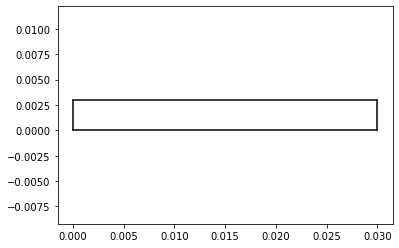

In [12]:
# Square System :
dz = 0.001
idx_out_walls = [1,2] # no out walls

segments = 0.001*3*np.array([[0,0,10,0], [0,0,0,1], [10,0,10,1], [0,1,10,1]]) # bottom, left, right, top
system = SystemCreator(segments)

offsets = system.get_offsets()
system_shape = system.system_shape()
a = system.get_dir_vects()
segments = system.get_segments()
extremal_values = system.get_extremal_values()

fig, ax = plt.subplots()
ax.axis('equal')
plot_boundaries(ax, segments)

In [113]:
AVOGADRO_CONSTANT = 6.02e23 # mol-1
# grid :
mean_number_per_cell = 1000
max_number_per_cell = 10*mean_number_per_cell
resolutions = np.array((20,2), dtype = int) # tube
grid = Grid(resolutions, max_number_per_cell)
volume_cell = dz * system_shape[0]/resolutions[0] * system_shape[1]/resolutions[1]

# Particles - 1 type 
density = 3.2e19 # m-3
n_simu = mean_number_per_cell*np.prod(resolutions) # number of particles in the simulated system
n_real = volume_cell * density * np.prod(resolutions) # number of particles in the real system
mr = n_real/n_simu # macro particules ratio = number of particles in the real system / number of macro part in the simulated system
density_dsmc = density/mr
temperature = 300 # K

part_type = 'I'
charge, mass, radius = 0, get_mass_part(53, 53, 74), 2e-10
size_array = 2*mean_number_per_cell*np.prod(resolutions)
v_mean = maxwellian_mean_speed(temperature, mass)
container = Particle(part_type, charge, mass, radius, size_array)
cross_section = container.get_params()[3]

# mean free path and time
mfp = mean_free_path(cross_section, density)
typical_lenght = 0.001
mft = mean_free_time(typical_lenght, v_mean = v_mean)

    # Injection params
in_wall = np.array([0,0,0,0.001], dtype = float) # tube
in_vect = np.array([1,0], dtype = float)

debit = maxwellian_flux(density_dsmc, v_mean)*np.linalg.norm(in_wall[:2]-in_wall[2:])*dz # particles per second
vel_std = gaussian(temperature, mass)

dt = 5e-7 # in sec, should be a fraction of the mean free time

# advection
def f(arr, dt):
    return np.zeros(shape = (arr.shape[0], 3))
args = []
scheme = euler_explicit

In [114]:
print('Input mass flow rate : {:.3e} kg/s'.format(mr*debit*mass))
print('Equivalent pressure : {:.3e} Pa'.format(density*8.314*temperature/AVOGADRO_CONSTANT))

Input mass flow rate : 3.786e-10 kg/s
Equivalent pressure : 1.326e-01 Pa


In [115]:
# NAME tests
from pathlib import Path

dir_path = Path('results/benchmark/tube-flow')

name_df = dir_path/'df.h5'
name_coll = dir_path/'collisions.npy'
name_monitor_dsmc = dir_path/'monitor-dsmc.npy'
name_pmax = dir_path/'pmaxes-evo.npy'
name_average = dir_path/'averages-evo.npy'

if(os.path.exists(dir_path)):
    os.system('rm -f -r {}'.format(dir_path))
os.makedirs(dir_path)

In [116]:
iterations = 10000

store = pd.HDFStore(name_df)

df = pd.DataFrame(columns = ['x','y','vx','vy','vz'])

remains = 0
saving_period = 100
adding_period = 10

averages = np.full(shape = grid.current.shape, fill_value = mean_number_per_cell)
pmax = 2*v_mean*cross_section*np.ones(averages.shape)
remains_per_cell = np.zeros(shape = grid.current.shape, dtype = float)

# dsmc saving
averages_evo = np.zeros((iterations, averages.shape[0], averages.shape[1]))
pmax_evo = np.zeros((iterations, pmax.shape[0], pmax.shape[1]))
arr_nb_colls = np.zeros((iterations, resolutions[0], resolutions[1]))
monitors = np.zeros((iterations, 3))

# delete partciles saving 
deleted_evo = np.zeros((iterations), dtype = int)
print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(' it ', ' INIT ', ' INJECT ', ' DEL ', ' TRY'))
print('{:-^56}'.format(''))

for it in range(iterations): # tqdm
    n1 = container.get_current()
                   
    # injecting particles - no injection
    new, remains = inject(in_wall, in_vect, debit, vel_std, radius, dt, remains)
    container.add_multiple(new)
                   
    n2 = container.get_current()-n1
    
    # PHASE : ADVECTING
        # MOVING PARTICLES
    arr = container.get_particles()
    
    if(it%adding_period == 0):
        df = df.append(pd.DataFrame(data=arr, index=[it]*arr.shape[0], columns = ['x','y','vx','vy','vz']))
    
    advect(arr, f, dt, args, scheme) # advect is inplace
    
        # HANDLING BOUNDARIES 
    arr_save = np.copy(arr)
    count = np.full(fill_value = True, shape = arr.shape[0])
    idxes_out = []
    c = 0
    while(np.sum(count, where = count == True) > 0):
        c+=1
        ct, cp = handler_wall_collision_point(arr[count], segments, a) # handler_wall_collision(arr[count], segments, a, radius)
        count, idxes_out_ = make_collisions_out_walls(arr, a, ct, cp, idx_out_walls, count) # idxes_out : indexes of the particles (in arr) that got out of the system
        idxes_out.append(idxes_out_)
    
    idxes_out = np.concatenate(idxes_out)
    # no need to delete anything (in theory)
    container.delete_multiple(idxes_out)
    deleted_evo[it] = len(idxes_out)
    arr = container.get_particles()
    
    # PHASE : COLLISIONS
        # UPDATING GRID - HARD RESET
    grid.reset()
    positions = pos_in_grid(arr[:,:2], resolutions, offsets, system_shape)
    particles = convert_to_grid_datatype(positions, new = positions.shape[0])
    grid.add_multiple(particles)
        
        # DSMC
        # TODO: make parallel
    currents = grid.get_currents()
    averages = (it*averages+currents)/(it+1) # may be it too violent ? 
    
    # saving for plotting later on
    pmax_evo[it,:,:] = pmax[:,:]
    averages_evo[it, :, :] = averages[:,:]
    
    remains_per_cell, nb_colls, new_pmax, monitor = handler_particles_collisions([arr], grid.get_grid(), currents, dt, averages, pmax, cross_section, volume_cell, mr, remains_per_cell, monitoring = True)
    monitors[it] = monitor
    arr_nb_colls[it,:,:] = nb_colls
    
    # PLOTTING AND SAVING (OPTIONAL)
    if(it%saving_period==0):
        store.append('df', df)
        df = pd.DataFrame(columns = ['x','y','vx','vy','vz']) # this way not too much memory is used
        print('|{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|'.format(it, n1, n2, idxes_out.shape[0], c))
   
# saving back
np.save(file = name_monitor_dsmc, arr = monitors, allow_pickle=False)
np.save(file = name_coll, arr = arr_nb_colls, allow_pickle=False)
np.save(file = name_pmax, arr = pmax_evo, allow_pickle=False)
np.save(file = name_average, arr = averages_evo, allow_pickle=False)
store.append('df', df)
store.close()

|    it    |   INIT   |  INJECT  |   DEL    |    TRY   |
--------------------------------------------------------
|    0     |    0     |    12    |    0     |    1     |
|   100    |   1237   |    12    |    0     |    2     |
|   200    |   2448   |    12    |    1     |    2     |
|   300    |   3399   |    12    |    3     |    2     |
|   400    |   4053   |    12    |    7     |    2     |
|   500    |   4539   |    12    |    11    |    2     |
|   600    |   4845   |    12    |    3     |    2     |
|   700    |   5117   |    12    |    11    |    2     |
|   800    |   5251   |    12    |    10    |    2     |
|   900    |   5400   |    12    |    13    |    2     |
|   1000   |   5529   |    12    |    11    |    2     |
|   1100   |   5609   |    12    |    13    |    2     |
|   1200   |   5685   |    12    |    8     |    2     |
|   1300   |   5760   |    12    |    17    |    2     |
|   1400   |   5823   |    12    |    15    |    2     |
|   1500   |   5943   |    12  

### Analysis

Objectives :
* Extract the speed of the flow to compare it to the theoretical one
* Compare mass flow rates in output

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# opening dataframe and array
store = pd.HDFStore(name_df)
df = store['df']
arr_nb_colls = np.load(name_coll)
monitors = np.load(name_monitor_dsmc)

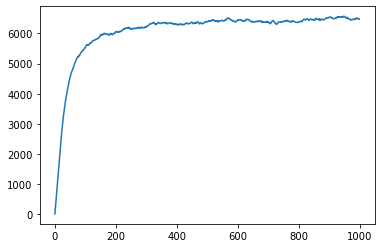

In [135]:
# plt.plot(df['x'].groupby(df.index).agg('count').values);
plt.plot(df.groupby(df.index).x.agg('count').values);

Total number of collision 23329


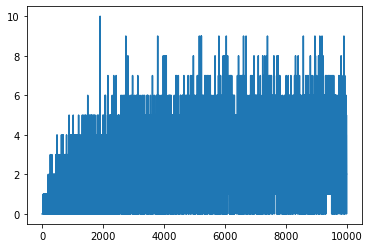

In [130]:
collisions_evo = np.sum(arr_nb_colls, axis = (1,2))
print('Total number of collision', int(np.sum(arr_nb_colls)));
# number of collisions - evolution
plt.plot(collisions_evo);

Mass flow rate : 3.773e-10 kg/s.


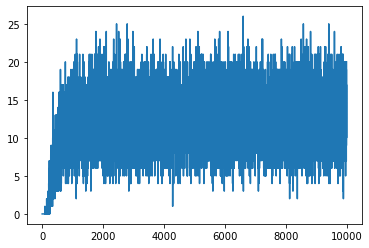

In [119]:
plt.plot(deleted_evo)

def compute_mass_flow_rate(qty, delta_time, mass):
    return qty*mass/delta_time

print('Mass flow rate : {:.3e} kg/s.'.format(compute_mass_flow_rate(mr*np.sum(deleted_evo[8000:]), delta_time = dt*2000, mass = mass)))

In [120]:
# Mach number and speed flow
min_it, max_it, step = iterations-2000, iterations, adding_period # we save every adding_period the state of the particles
iterations_list = [k for k in range(min_it, max_it, step)]
df_it = df.loc[np.isin(df.index,iterations_list) & (df['x']>0.009)]
flow_speed = np.mean(df_it['vx'])

In [121]:
print('Mean speed along the x-axis for the last cell : {:.3e} m/s'.format(flow_speed))

Mean speed along the x-axis for the last cell : 1.156e+02 m/s
